In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
# D = np.load('drifting_gratings_data.npz')
D = np.load('static_gratings_data_4ms.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = D['bin_len']

D = np.load('cell_types71.npz')
cell_types = D['cell_types']

In [3]:
ord_idxs = np.argsort(CCmaxs)[-30:]
# ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-4:]))
ord_types = cell_types[ord_idxs]
print np.unique(cell_types[ord_idxs],return_counts=True)
print CCmaxs[ord_idxs[-1]]

(array(['exc_VISp_1', 'exc_VISp_5', 'inh_VISp_1', 'inh_VISp_4',
       'inh_VISp_5'], dtype='|S10'), array([ 2,  3,  5,  5, 15]))
0.970670612248924


In [4]:
#helper functions for fitting GLM models
from scipy.stats import pearsonr
from scipy.misc import factorial

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh 
    
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T = binned_spikes.size
    X_dsn = np.ones((T-dmax,M*d1+d2+1))
    for t in range(T-dmax):
        X_dsn[t,:M*d1] = flat_stimulus[:,t+dmax+1-d1:t+dmax+1].reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d,val_stim=None,val_spks=None):
    d1,d2 = d
    dmax = max(d)
    y = spks.reshape([-1,1])
    model =  sm.GLM(y,construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    m_it = 200 #24
    model_results = model.fit(maxiter=m_it)
    print model_results.fit_history['iteration']
    conved = m_it!=model_results.fit_history['iteration']
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d2]
    stim_se = se[:-1-d2]
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
    smooth_spks = np.convolve(spks,filt,mode='same')
    train_corr = pearsonr(model.predict(p),smooth_spks)[0]
    dev = model_results.deviance
#     print dev, 2*(np.sum(-y+y*np.log(y+1e-20)-np.log(factorial(y)))-model_results.llf)
    if val_stim is not None:
        val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
        val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
        smooth_val_spks = np.convolve(val_spks,filt,mode='same')
        val_corr = pearsonr(val_model.predict(p),smooth_val_spks)[0]
        return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, dev, conved



In [5]:
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [6]:

# K = 3 # number of harmonics
# L = 2*K+1
# conds = np.unique(stim,axis=1)  
# mod_stim_sin = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
# ind_old = -1
# for t in range(stim.shape[1]):
#     if stim[0,t]>0:
#         ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
#         if ind!=ind_old:
#             t0=t
#             ind_old=ind
#         mod_stim_sin[(ind-1)*L,t] = 1
#         for k in range(K):
#             mod_stim_sin[(ind-1)*L+2*k+1,t] = np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
#             mod_stim_sin[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
#     else:
#         ind_old = -1

In [7]:
mod_stim_start = np.concatenate((np.zeros((mod_stim.shape[0],1)),np.diff(mod_stim,axis=1)),axis=1)>0

(-0.5, 4999.5, 120.5, -0.5)

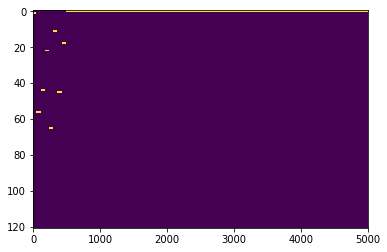

In [69]:
# # print np.unique(mod_stim_sin)
# x = np.hstack((mod_stim[:,:64000],mod_stim[:,156000:224000],mod_stim[:,316000:]))
# # plt.imshow(x,cmap='Greys')
plt.imshow(mod_stim[:,int(2280/bin_len):int(2300/bin_len)])
# plt.imshow(mod_stim)
plt.axis('tight')

(-0.5, 242499.5, 120.5, -0.5)

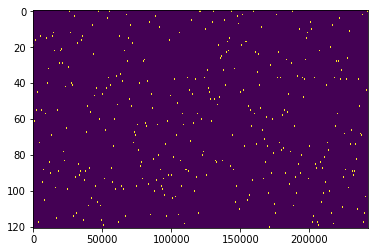

In [71]:
# train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),int(2200/bin_len))))
train_inds = np.concatenate((np.arange(int(485/bin_len)),np.arange(int(1800/bin_len),int(2285/bin_len))))
plt.imshow(mod_stim[:,train_inds])
#3210-end
plt.axis('tight')

In [72]:
d = [1,30]
# ts = int(600*bin_len)

# stim_filt, spk_filt, b, stim_se, spk_se, bse, nnll, corr, dev = fit_GLM(mod_stim[:,:],binned_spikes[ord_idxs[-1],:],d)
stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved = fit_GLM(mod_stim[:,train_inds],binned_spikes[ord_idxs[-1],train_inds],d,val_stim = mod_stim[:,int(3200/bin_len):], val_spks = binned_spikes[ord_idxs[-1],int(3200/bin_len):])


25


0.042099710315369625 0.3769217392853333 -5.2611355437900205 1876.5341551983133


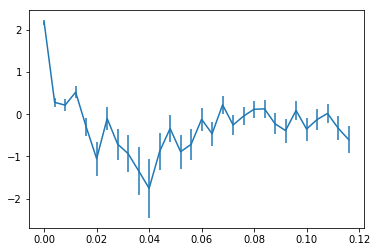

In [73]:
plt.errorbar(np.arange(d[1])*bin_len,spk_filt,yerr=spk_se)
# plt.ylim([-100,100])
print train_nnll, train_corr, b, bse

In [12]:
# from scipy.stats import chi2
# pval = chi2.sf((dev_noW-dev_W),df=d[1])
# print pval

0.02138898766653108 0.022236227663281857


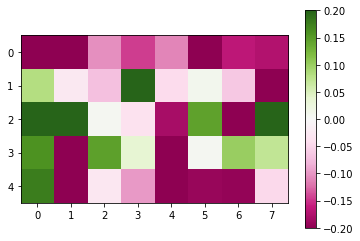

In [13]:
print stim_filt[0], stim_se[0]
plt.imshow(stim_filt[1:].reshape(5,8),cmap='PiYG',vmin=-.2,vmax=.2)
# print stim_filt[-1], stim_se[-1]
# plt.imshow(np.sqrt(np.square(stim_filt[0:-1:2])+np.square(stim_filt[1:-1:2])).reshape(5,8))
plt.colorbar()

# plt.errorbar(np.arange(stim_filt.size),stim_filt,yerr=stim_se)

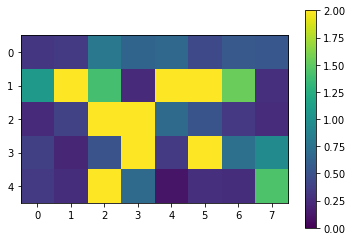

In [14]:
plt.imshow((stim_se[1:]/np.abs(stim_filt[1:])).reshape(5,8), vmin=0, vmax=2)
# plt.imshow(np.sqrt(np.square(stim_se[0:-1:2])+np.square(stim_se[1:-1:2])).reshape(5,8))
plt.colorbar()

In [75]:
import gc
train_nnlls = []
val_nnlls = []
train_corrs = []
val_corrs = []
devs = []
conveds = []
Ws = []
Fs = []
bs = []
d = [1,10]
for idx in ord_idxs:
    stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved = fit_GLM(mod_stim[:,train_inds],binned_spikes[idx,train_inds],d,val_stim = mod_stim[:,int(3200/bin_len):], val_spks = binned_spikes[idx,int(3200/bin_len):])
    Fs.append(stim_filt)
    Ws.append(spk_filt)
    bs.append(b)
    train_nnlls.append(train_nnll)
    val_nnlls.append(val_nnll)
    train_corrs.append(train_corr)
    val_corrs.append(val_corr)
    devs.append(dev)
    conveds.append(conved)
    gc.collect()
    

MemoryError: 

0


(0, 1)

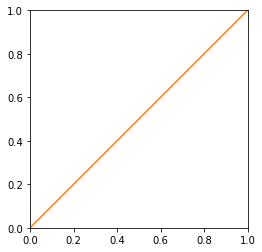

In [26]:
lims = [0,1]
print np.array(val_nnlls)[np.array(conveds)==True].size
plt.plot(np.array(val_nnlls)[np.array(conveds)==True],np.array(train_nnlls)[np.array(conveds)==True],'o')
plt.plot(lims,lims)
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)


In [51]:
np.savez('driftinggs_noW_sm',train_losses = np.array(train_nnlls), val_losses = np.array(val_nnlls), train_corrs = np.array(train_corrs), val_corrs = np.array(val_corrs), devs = np.array(devs), conveds = np.array(conveds))
